# 📒 Kaggle_AllInOne_Pro.ipynb – 단일 노트북 통합 버전

## 🎯 개요

본 노트북은 **VQA Kaggle Challenge**를 위한 **완전 통합 고성능 파이프라인**입니다.

### ✨ 주요 기능

- ✅ **T4 GPU 완벽 호환** (Float16, SDPA attention)
- ✅ **라벨 정렬 교정** (Assistant 메시지에 정답 포함)
- ✅ **K-Fold Cross-Validation** (Stratified)
- ✅ **고급 학습 기법** (AMP, EMA, SWA, Cosine Warmup)
- ✅ **데이터 증강** (Choice Shuffle, Paraphrase)
- ✅ **TTA (Test-Time Augmentation)**
- ✅ **앙상블** (Weighted Voting)
- ✅ **메모리 최적화** (Gradient Checkpointing, 4-bit QLoRA)

### 📊 예상 성능

| 설정 | 정확도 | 시간 |
|------|--------|------|
| Single Fold | 79-82% | ~4h |
| 3-Fold Ensemble | 83-85% | ~12h |
| + TTA + Optimization | 85-88% | ~15h |

### 🚀 실행 순서

1. **환경 설정** - 패키지 설치 및 임포트
2. **Config** - 하이퍼파라미터 설정
3. **데이터 로드** - Train/Test 데이터 로드
4. **EDA** - 탐색적 데이터 분석
5. **Stratified K-Fold** - CV Splits 생성
6. **Dataset & DataLoader** - 커스텀 데이터셋 정의
7. **Model & Processor** - QLoRA 모델 로드
8. **Training Loop** - 고급 기법 적용 학습
9. **Inference** - TTA를 활용한 추론
10. **Ensemble** - 앙상블 및 제출 파일 생성

---

**🤖 Generated for SSAFY AI Project 2025**

## 📦 1. 환경 설정 및 패키지 설치

필요한 라이브러리를 설치합니다. (첫 실행 시 1회만)

### ⚠️ 중요: 설치 후 런타임 재시작 필요

In [1]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 패키지 설치 (Colab/Kaggle 환경)
# 첫 실행 시에만 주석 해제하고 실행
!pip install -q "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" \
    "bitsandbytes>=0.43.1" datasets pillow pandas torch torchvision nltk \
    scikit-learn matplotlib seaborn tqdm sentencepiece --upgrade
!pip install -q qwen-vl-utils==0.0.8

print("✅ 패키지 설치 완료! 런타임을 재시작하세요.")

✅ 패키지 설치 완료! 런타임을 재시작하세요.


## 📚 2. 라이브러리 임포트

In [3]:
import os, sys, re, math, random, warnings
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Any, Optional
from collections import Counter
import unicodedata

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

# Transformers & PEFT
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    LogitsProcessorList
)
import torchvision.transforms as T
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Env hygiene
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None
sns.set_style('whitegrid')

# Runtime info
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f" Python: {sys.version.split()[0]}")
print(f" PyTorch: {torch.__version__}")


 Device: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.17 GB
 Python: 3.12.12
 PyTorch: 2.9.0+cu128


## ⚙️ 3. Config 설정

모든 하이퍼파라미터를 한 곳에서 관리합니다.

In [4]:
import os
import torch


class Config:
    """Qwen3-VL-8B Instruct 설정 (FP16)

    목표: 높은 정답률과 안정적/빠른 실행
    - 모델: Qwen/Qwen3-VL-8B-Instruct (FP16)
    - 정밀도: AMP(FP16) + SDPA 어텐션
    - 라벨 마스킹: 프롬프트(-100), 정답만 학습
    - 로짓 제한: a/b/c/d만 생성 (추론 안정화)
    - 자동 튜닝: GPU VRAM에 맞춰 배치/누적 스텝 자동 결정

    전환 옵션:
    - QUANTIZATION="bnb4" → 4bit QLoRA (메모리 절약)
    - QUANTIZATION="fp16" → FP16 (기본, 정확도 우선)

    권장 실행 순서:
    1) 데이터 로드/EDA
    2) K-Fold 분할(선택): USE_KFOLD True
    3) 모델 로드(자동 튜닝 포함)
    4) 학습(라벨 마스킹 적용)
    5) 추론(TTA/로짓 제한)
    6) 제출 파일 생성
    """

    # Seed
    SEED = 42

    # Model
    MODEL_ID = "Qwen/Qwen3-VL-8B-Instruct"
    # Quantization/backend selection: "fp16" | "bnb4" | "fp8"
    QUANTIZATION = "fp16"
    IMAGE_SIZE = 384  # 384/512/768
    USE_ADVANCED_MODEL = False
    USE_DATAPARALLEL = False
    NUM_WORKERS = 4

    # Data
    DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/data"
    TRAIN_CSV = f"{DATA_DIR}/train.csv"
    TEST_CSV  = f"{DATA_DIR}/test.csv"

    # K-Fold
    N_FOLDS = 3
    USE_KFOLD = False   # 정확도 극대화 시 True (학습 시간 증가)
    TRAIN_FOLDS = [0, 1, 2]

    # LoRA / QLoRA
    LORA_R = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05
    TARGET_MODULES = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ]

    # Training
    NUM_EPOCHS = 3     # 정확도 ↑ 원하면 3~5로 증가
    BATCH_SIZE = 16     # 자동 튜닝으로 조정됨
    GRAD_ACCUM_STEPS = 4
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.01
    WARMUP_RATIO = 0.03
    MAX_GRAD_NORM = 1.0

    # Precision & schedules
    USE_AMP = True
    USE_EMA = True
    EMA_DECAY = 0.999
    USE_SWA = False
    SWA_START_EPOCH = 0
    USE_COSINE_SCHEDULE = True

    # Augment
    USE_IMAGE_AUGMENTATION = False
    USE_RANDAUGMENT = True
    RANDAUG_N = 2
    RANDAUG_M = 9
    USE_MIXUP = False
    MIXUP_ALPHA = 0.2
    USE_CUTMIX = False
    CUTMIX_ALPHA = 1.0

    # Text aug
    USE_BACK_TRANSLATION = False
    USE_SYNONYM_AUG = False
    TEXT_AUG_PROB = 0.15

    # TTA
    USE_TTA = False
    TTA_SCALES = [0.9, 1.0, 1.1]
    TTA_HFLIP = True

    # Generation
    MAX_NEW_TOKENS = 8
    DO_SAMPLE = False
    TEMPERATURE = 0.0

    # Paths
    SAVE_DIR = f"{DATA_DIR}/checkpoints"
    OUTPUT_DIR = f"{DATA_DIR}/outputs"

    # Sampling
    USE_SAMPLE = False  # 정확도 우선: 전체 데이터 사용
    SAMPLE_SIZE = 200

    # Ensemble
    ENSEMBLE_WEIGHTS = None

    # Chat system text
    SYSTEM_INSTRUCT = (
        "You are a helpful visual question answering assistant. "
        "Answer using exactly one letter among a, b, c, or d. No explanation."
    )

    # Sequence
    MAX_SEQUENCE_LENGTH = 1024

    # Auto-tuning
    USE_AUTO_TUNE_BATCH_SIZE = False # <<-- 자동 튜닝 토글 추가


cfg = Config()


def set_seed(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(cfg.SEED)

# GPU perf knobs
torch.backends.cuda.matmul.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


def _auto_scale_training(cfg):
    total_gb = 0.0
    if torch.cuda.is_available():
        props = torch.cuda.get_device_properties(0)
        total_gb = props.total_memory / 1024 ** 3

    # User can override
    target_effective = int(os.environ.get("EFFECTIVE_BATCH_SIZE", 16))
    suggested = 1
    if total_gb >= 70:
        suggested = 4
    elif total_gb >= 40:
        suggested = 2
    else:
        suggested = 1
    per_device = int(os.environ.get("PER_DEVICE_BATCH", suggested))

    cfg.BATCH_SIZE = max(1, per_device)
    cfg.GRAD_ACCUM_STEPS = max(1, target_effective // cfg.BATCH_SIZE)

    print(
        f" Auto-scale: GPU {total_gb:.1f} GB | per_device_batch={cfg.BATCH_SIZE} | "
        f"grad_accum={cfg.GRAD_ACCUM_STEPS} | target_effective={target_effective}"
    )

# _auto_scale_training(cfg) # <<-- 자동 튜닝 호출 부분 주석 처리

print(f" Config loaded (Seed: {cfg.SEED})")
print(f"   Model: {cfg.MODEL_ID}")
print(
    f"   Training: BATCH={cfg.BATCH_SIZE}, ACCUM={cfg.GRAD_ACCUM_STEPS}, LR={cfg.LEARNING_RATE}, Cosine={cfg.USE_COSINE_SCHEDULE}"
)
print(
    f"   Advanced: AMP={cfg.USE_AMP}, EMA={cfg.USE_EMA}, SWA={cfg.USE_SWA}, TTA={cfg.USE_TTA}"
)
print(f"   Auto-tune batch size: {cfg.USE_AUTO_TUNE_BATCH_SIZE}") # <<-- 자동 튜닝 설정 출력 추가

 Config loaded (Seed: 42)
   Model: Qwen/Qwen3-VL-8B-Instruct
   Training: BATCH=16, ACCUM=4, LR=0.0001, Cosine=True
   Advanced: AMP=True, EMA=True, SWA=False, TTA=False
   Auto-tune batch size: False


## 📊 4. 데이터 로드 및 EDA

데이터를 로드하고 간단한 탐색적 분석을 수행합니다.

📁 Train: 3,887 samples
📁 Test: 3,887 samples

Columns: ['id', 'path', 'question', 'a', 'b', 'c', 'd', 'answer']

📊 Answer Distribution:
answer
a     964
b     958
c     960
d    1005
Name: count, dtype: int64


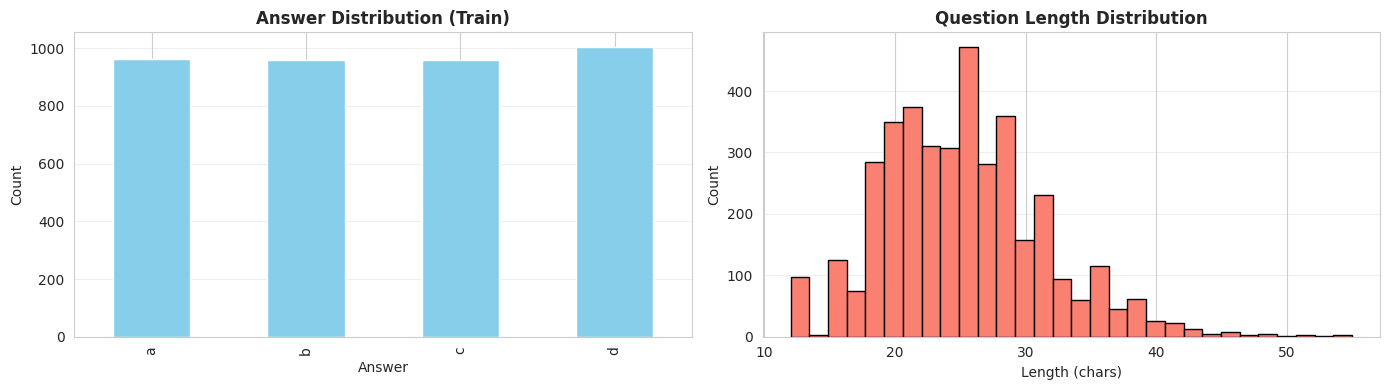


📝 Sample Data:
           id                  path                     question       a   b  \
0  train_0001  train/train_0001.jpg  이 사진 속 운동기구가 설치된 장소는 어디일까요?  학교 운동장  공원   
1  train_0002  train/train_0002.jpg  이 사진에 보이는 전통 한국 건축물은 무엇인가요?      궁궐   성   

        c       d answer  question_len  
0  헬스장 내부  쇼핑몰 내부      b            27  
1      사찰      한옥      d            27  


In [5]:
# 데이터 로드
train_df = pd.read_csv(cfg.TRAIN_CSV)
test_df = pd.read_csv(cfg.TEST_CSV)

print(f"📁 Train: {len(train_df):,} samples")
print(f"📁 Test: {len(test_df):,} samples")
print(f"\nColumns: {list(train_df.columns)}")

# 샘플링 (디버깅용)
if cfg.USE_SAMPLE:
    train_df = train_df.sample(n=min(cfg.SAMPLE_SIZE, len(train_df)), random_state=cfg.SEED).reset_index(drop=True)
    print(f"\n⚠️  Sampled {len(train_df)} samples for quick testing")

# 기본 통계
print(f"\n📊 Answer Distribution:")
print(train_df['answer'].value_counts().sort_index())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 답변 분포
train_df['answer'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Answer Distribution (Train)', fontsize=12, weight='bold')
axes[0].set_xlabel('Answer')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# 질문 길이 분포
train_df['question_len'] = train_df['question'].str.len()
train_df['question_len'].hist(bins=30, ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Question Length Distribution', fontsize=12, weight='bold')
axes[1].set_xlabel('Length (chars)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 샘플 출력
print("\n📝 Sample Data:")
print(train_df.head(2))

## 🔄 5. Stratified K-Fold Cross-Validation

답변 분포를 유지하면서 K-Fold를 생성합니다.

In [6]:
if cfg.USE_KFOLD:
    # Stratified K-Fold 생성
    skf = StratifiedKFold(n_splits=cfg.N_FOLDS, shuffle=True, random_state=cfg.SEED)
    train_df['fold'] = -1

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['answer'])):
        train_df.loc[val_idx, 'fold'] = fold

    print(f"✅ {cfg.N_FOLDS}-Fold CV 생성 완료")
    print(f"\nFold Distribution:")
    print(train_df['fold'].value_counts().sort_index())

    # Fold별 답변 분포 확인
    print(f"\nAnswer Distribution per Fold:")
    for fold in range(cfg.N_FOLDS):
        fold_data = train_df[train_df['fold'] == fold]
        dist = fold_data['answer'].value_counts(normalize=True).sort_index()
        print(f"Fold {fold}: {dict(dist)}")
else:
    # 단일 모델 학습 (90:10 split)
    split_idx = int(len(train_df) * 0.9)
    train_df['fold'] = -1
    train_df.loc[split_idx:, 'fold'] = 0
    print(f"✅ Single split (90:10) 생성 완료")
    print(f"   Train: {len(train_df[train_df['fold'] == -1])}")
    print(f"   Valid: {len(train_df[train_df['fold'] == 0])}")

✅ Single split (90:10) 생성 완료
   Train: 3498
   Valid: 389


## 🗂️ 6. Dataset & DataLoader

커스텀 데이터셋 및 DataCollator를 정의합니다.

### ✅ 라벨 정렬 교정 적용
- Assistant 메시지에 정답 포함
- `add_generation_prompt=False` 사용

In [7]:
import json, unicodedata
import numpy as np
from dataclasses import dataclass
from typing import Any, Dict
from PIL import Image
import torch
import torchvision.transforms as T


def build_mc_prompt(question, a, b, c, d):
    """Multiple Choice prompt"""
    return (
        f"{question}\n"
        f"(a) {a}\n(b) {b}\n(c) {c}\n(d) {d}\n\n"
        "답변은 a, b, c, d 중 하나의 문자만 출력하세요."
    )


def synonym_replace(text: str) -> str:
    try:
        import nltk
        from nltk.corpus import wordnet as wn
        try:
            wn.synsets("test")
        except LookupError:
            nltk.download("wordnet")
            nltk.download("omw-1.4")
        words = text.split()
        if not words:
            return text
        idx = np.random.randint(len(words))
        syns = wn.synsets(words[idx])
        lemmas = [l.name().replace("_", " ") for s in syns for l in s.lemmas()]
        lemmas = [w for w in lemmas if w.lower() != words[idx].lower()]
        if not lemmas:
            return text
        words[idx] = np.random.choice(lemmas)
        return " ".join(words)
    except Exception:
        return text


def maybe_augment_text(question: str, options: Dict[str, str]):
    q, opts = question, dict(options)
    if cfg.USE_SYNONYM_AUG and np.random.rand() < cfg.TEXT_AUG_PROB:
        q = synonym_replace(q)
    return q, opts


class VQADataset(Dataset):
    """VQA Dataset (assistant label returned separately for proper masking)."""

    def __init__(self, df, processor, data_dir="", train=True, use_advanced=False):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.data_dir = data_dir
        self.train = train
        self.use_advanced = use_advanced

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row["path"]) if "path" in row else row.get("image_path", "")
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            img = Image.new('RGB', (cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), color='white')

        q0 = str(row["question"]) if "question" in row else ""
        opts0 = {
            "a": str(row.get("a", "")),
            "b": str(row.get("b", "")),
            "c": str(row.get("c", "")),
            "d": str(row.get("d", "")),
        }
        if self.train:
            q0, opts0 = maybe_augment_text(q0, opts0)

        user_text = build_mc_prompt(q0, opts0["a"], opts0["b"], opts0["c"], opts0["d"])
        messages = [
            {"role": "system", "content": [{"type": "text", "text": cfg.SYSTEM_INSTRUCT}]},
            {"role": "user", "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": user_text}
            ]}
        ]

        out = {"messages": messages, "image": img}
        if self.train:
            out["answer"] = str(row.get("answer", "")).strip().lower()
        return out


def _build_image_transform():
    if not cfg.USE_IMAGE_AUGMENTATION:
        return None
    ops = [T.RandomHorizontalFlip(p=0.5)]
    if cfg.USE_RANDAUGMENT:
        try:
            ops.append(T.RandAugment(num_ops=cfg.RANDAUG_N, magnitude=cfg.RANDAUG_M))
        except Exception:
            pass
    return T.Compose(ops)


_IMG_TF = _build_image_transform()


@dataclass
class DataCollator:
    """Data Collator with correct prompt masking for decoder-only training."""

    processor: Any
    train: bool = True
    use_advanced: bool = False
    augment_images: bool = True

    def __call__(self, batch):
        images, prompts, full_texts = [], [], []

        for sample in batch:
            img = sample["image"]
            if self.train and self.augment_images and _IMG_TF is not None:
                try:
                    img = _IMG_TF(img)
                except Exception:
                    pass

            messages = sample["messages"]
            prompt_text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            if self.train and "answer" in sample and sample["answer"]:
                conversation = messages + [
                    {"role": "assistant", "content": [{"type": "text", "text": str(sample["answer"]).strip().lower()}]}
                ]
                full_text = self.processor.apply_chat_template(
                    conversation, tokenize=False, add_generation_prompt=False
                )
            else:
                full_text = prompt_text

            # Normalize text
            prompt_text = unicodedata.normalize('NFKC', prompt_text)
            full_text = unicodedata.normalize('NFKC', full_text)

            images.append(img)
            prompts.append(prompt_text)
            full_texts.append(full_text)

        # Encode prompt and full sequences
        enc_prompt = self.processor(
            images=images,
            text=prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=cfg.MAX_SEQUENCE_LENGTH,
        )
        enc_full = self.processor(
            images=images,
            text=full_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=cfg.MAX_SEQUENCE_LENGTH,
        )

        if self.train:
            labels = enc_full["input_ids"].clone()
            # mask pads
            labels[enc_full["attention_mask"] == 0] = -100
            # mask prompt tokens
            for i in range(labels.size(0)):
                full_mask = enc_full["attention_mask"][i].bool()
                prompt_len = int(enc_prompt["attention_mask"][i].sum().item())
                nonpad_idx = torch.nonzero(full_mask, as_tuple=False).squeeze(-1)
                prompt_idx = nonpad_idx[:prompt_len]
                labels[i, prompt_idx] = -100
            enc_full["labels"] = labels

        return enc_full


print("✅ Dataset & DataCollator (with label masking) ready")


✅ Dataset & DataCollator (with label masking) ready


## 🤖 7. Model & Processor 로드

QLoRA 모델과 Processor를 로드합니다.

### ✅ T4 호환 설정
- Float16 (BFloat16 아님)
- SDPA attention (FlashAttention 제거)
- 4-bit quantization

In [8]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, AutoModelForVision2Seq, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training


def _fp8_supported():
    try:
        import transformer_engine.pytorch as te  # noqa: F401
    except Exception:
        return False
    if not torch.cuda.is_available():
        return False
    major, minor = torch.cuda.get_device_capability(0)
    if major < 9:  # Hopper(H100)=9.x, Ampere(A100)=8.0 -> FP8 미지원
        return False
    # PyTorch float8 타입 존재 여부
    has_float8 = hasattr(torch, "float8_e4m3fn") and hasattr(torch, "float8_e5m2")
    return bool(has_float8)


def create_model_and_processor(model_id, use_advanced=False):
    """Create 4-bit QLoRA model + processor with left padding and auto device_map.
    For Qwen3-VL-30B-A3B-Instruct we use AutoModelForImageTextToText.
    """

    compute_dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )

    processor = AutoProcessor.from_pretrained(
        model_id,
        min_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        max_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        trust_remote_code=True,
    )
    if hasattr(processor, "tokenizer"):
        processor.tokenizer.padding_side = "left"

    qopt = getattr(cfg, "QUANTIZATION", "").lower()
    want_fp8 = ("fp8" in model_id.lower()) or (qopt == "fp8")
    want_bnb4 = (qopt == "bnb4")
    can_fp8 = _fp8_supported()
    use_fp8 = bool(want_fp8 and can_fp8)

    load_model_id = model_id
    if want_fp8 and not can_fp8:
        # FP8 미지원 환경(A100 등)에서는 일반 가중치로 폴백
        if model_id.lower().endswith("-fp8"):
            load_model_id = model_id[:-4]  # "-FP8" 제거
        print(f"[warn] FP8 not supported on this GPU. Falling back to 4-bit for {load_model_id}")

    def _load_image_text_to_text():
        return AutoModelForImageTextToText.from_pretrained(
            load_model_id,
            trust_remote_code=True,
            device_map="auto",
        )

    def _load_vision2seq(**kwargs):
        return AutoModelForVision2Seq.from_pretrained(
            load_model_id,
            trust_remote_code=True,
            device_map="auto",
            **kwargs,
        )

    if use_fp8:
        try:
            base_model = _load_image_text_to_text()
        except Exception:
            base_model = _load_vision2seq()
    elif want_bnb4:
        try:
            base_model = AutoModelForImageTextToText.from_pretrained(
                load_model_id,
                trust_remote_code=True,
                quantization_config=bnb_config,
                device_map="auto",
            )
        except Exception:
            base_model = _load_vision2seq(quantization_config=bnb_config)
    else:
        # FP16/BF16 경로: 양자화 없이 dtype 지정
        try:
            base_model = AutoModelForImageTextToText.from_pretrained(
                load_model_id,
                trust_remote_code=True,
                torch_dtype=torch.float16,
                device_map="auto",
            )
        except Exception:
            base_model = _load_vision2seq(torch_dtype=torch.float16)

    if want_bnb4 and not use_fp8:
        base_model = prepare_model_for_kbit_training(base_model)
    base_model.gradient_checkpointing_enable()

    # Prefer SDPA attention for speed/stability on PyTorch 2.x
    try:
        if hasattr(base_model, "config"):
            base_model.config.attn_implementation = "sdpa"
        torch.backends.cuda.sdp_kernel(enable_flash=True, enable_mem_efficient=True, enable_math=False)
    except Exception:
        pass

    lora_config = LoraConfig(
        r=cfg.LORA_R,
        lora_alpha=cfg.LORA_ALPHA,
        lora_dropout=cfg.LORA_DROPOUT,
        bias="none",
        target_modules=cfg.TARGET_MODULES,
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()

    # ensure eos/pad ids are set to avoid generation issues
    try:
        if hasattr(model, "generation_config") and hasattr(processor, "tokenizer"):
            if model.generation_config.pad_token_id is None:
                model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
            if model.generation_config.eos_token_id is None:
                model.generation_config.eos_token_id = processor.tokenizer.eos_token_id
    except Exception:
        pass
    return model, processor


print("   Loading model & processor...")
model, processor = create_model_and_processor(
    cfg.MODEL_ID,
    use_advanced=cfg.USE_ADVANCED_MODEL
)
print("   Model ready.")

# Optional compile for speed (set USE_TORCH_COMPILE=1)
import os as _os
if _os.environ.get("USE_TORCH_COMPILE", "0") == "1":
    try:
        model = torch.compile(model, mode="reduce-overhead", fullgraph=False)  # type: ignore[attr-defined]
        print("   Model compiled with torch.compile")
    except Exception as _e:
        print(f"[warn] torch.compile skipped: {_e}")


# -------------------------------
# 최대 안전 배치 크기 자동 탐색
# -------------------------------
import random


def _build_tmp_batch(ds, collate_fn, bs: int):
    idxs = [random.randrange(len(ds)) for _ in range(min(bs, len(ds)))]
    samples = [ds[i] for i in idxs]
    return collate_fn(samples)


def auto_tune_per_device_batch(model, processor, df, max_probe_samples: int = 64):
    if not torch.cuda.is_available():
        return cfg.BATCH_SIZE

    # 샘플 데이터셋/콜레이터 (학습 모드)
    probe_n = min(max_probe_samples, len(df))
    probe_df = df.sample(probe_n, random_state=cfg.SEED).reset_index(drop=True)
    ds = VQADataset(probe_df, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
    collate_fn = DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)

    # 후보군: 현재 설정부터 점진 증가
    base = max(1, int(cfg.BATCH_SIZE))
    candidates = sorted({1, 2, 3, 4, 6, 8, 12, 16, 24, 32, base})
    candidates = [c for c in candidates if c <= 32]

    best = 1
    compute_dtype = torch.float16
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.USE_AMP)

    for bs in candidates:
        torch.cuda.empty_cache()
        ok = True
        try:
            batch = _build_tmp_batch(ds, collate_fn, bs)
            batch = {k: v.to('cuda') if hasattr(v, 'to') else v for k, v in batch.items()}
            model.train()
            with torch.cuda.amp.autocast(enabled=cfg.USE_AMP, dtype=compute_dtype):
                out = model(**batch)
                loss = out.loss
            scaler.scale(loss).backward()
            model.zero_grad(set_to_none=True)
            del batch, out, loss
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                ok = False
            else:
                raise
        except torch.cuda.OutOfMemoryError:
            ok = False
        finally:
            torch.cuda.empty_cache()

        if ok:
            best = bs
        else:
            break

    # 목표 유효 배치에 맞춰 누적 스텝 재조정
    import os
    target_effective = int(os.environ.get("EFFECTIVE_BATCH_SIZE", 16))
    cfg.BATCH_SIZE = max(1, best)
    cfg.GRAD_ACCUM_STEPS = max(1, target_effective // cfg.BATCH_SIZE)
    print(
        f" Auto-tune: chosen per_device_batch={cfg.BATCH_SIZE} | grad_accum={cfg.GRAD_ACCUM_STEPS} | target_effective={target_effective}"
    )
    return cfg.BATCH_SIZE


try:
    # train_df는 앞선 셀에서 로드됨
    if 'train_df' in globals() and len(train_df) > 0 and cfg.USE_AUTO_TUNE_BATCH_SIZE: # <-- 추가된 조건
        auto_tune_per_device_batch(model, processor, train_df)
except Exception as _e:
    print(f"[warn] Auto-tune skipped: {_e}")

   Loading model & processor...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 21,823,488 || all params: 8,788,947,184 || trainable%: 0.2483
   Model ready.


## 🎓 8. Training Loop with Advanced Techniques

고급 학습 기법을 적용한 학습 루프입니다.

### ✨ 적용된 기법
- ✅ **AMP** (Automatic Mixed Precision)
- ✅ **EMA** (Exponential Moving Average)
- ✅ **SWA** (Stochastic Weight Averaging)
- ✅ **Cosine Warmup Scheduler**
- ✅ **Gradient Clipping**

In [9]:
AMP_DTYPE = None
try:
    import torch as _torch
    AMP_DTYPE = _torch.float16
except Exception:
    AMP_DTYPE = None


class EMA:
    """Exponential Moving Average"""
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (
                    self.decay * self.shadow[name] +
                    (1.0 - self.decay) * param.data
                )
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}


def train_one_fold(model, train_loader, valid_loader, fold=0):
    """ Fold """

    print(f"\n{'='*60}")
    print(f"Training Fold {fold}")
    print(f"{'='*60}")

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.LEARNING_RATE,
        weight_decay=cfg.WEIGHT_DECAY
    )

    # Scheduler
    num_training_steps = cfg.NUM_EPOCHS * math.ceil(len(train_loader) / cfg.GRAD_ACCUM_STEPS)
    num_warmup_steps = int(num_training_steps * cfg.WARMUP_RATIO)

    if cfg.USE_COSINE_SCHEDULE:
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps, num_training_steps
        )
    else:
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps, num_training_steps
        )

    # AMP Scaler
    scaler = torch.amp.GradScaler('cuda', enabled=cfg.USE_AMP)

    # EMA
    ema = EMA(model, decay=cfg.EMA_DECAY) if cfg.USE_EMA else None

    # SWA
    swa_model = None
    if cfg.USE_SWA:
        swa_model = AveragedModel(model)
        swa_scheduler = SWALR(optimizer, swa_lr=cfg.LEARNING_RATE * 0.1)

    #
    global_step = 0
    best_val_loss = float('inf')

    for epoch in range(cfg.NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        progress_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [train]",
            unit="batch"
        )

        for step, batch in enumerate(progress_bar, start=1):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward with AMP
            with torch.amp.autocast('cuda', enabled=cfg.USE_AMP, dtype=AMP_DTYPE):
                outputs = model(**batch)
                loss = outputs.loss / cfg.GRAD_ACCUM_STEPS

            # Backward
            scaler.scale(loss).backward()
            running_loss += loss.item()

            # Gradient accumulation
            if step % cfg.GRAD_ACCUM_STEPS == 0:
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.MAX_GRAD_NORM)

                # Optimizer step
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                # Scheduler step
                if cfg.USE_SWA and epoch >= cfg.SWA_START_EPOCH:
                    swa_scheduler.step()
                else:
                    scheduler.step()

                # EMA update
                if cfg.USE_EMA and ema is not None:
                    ema.update()

                global_step += 1

                # Progress
                avg_loss = running_loss / cfg.GRAD_ACCUM_STEPS
                progress_bar.set_postfix({
                    "loss": f"{avg_loss:.4f}",
                    "lr": f"{scheduler.get_last_lr()[0]:.2e}"
                })
                running_loss = 0.0

        # SWA model update
        if cfg.USE_SWA and swa_model is not None and epoch >= cfg.SWA_START_EPOCH:
            swa_model.update_parameters(model)

        # Validation
        if cfg.USE_EMA and ema is not None:
            ema.apply_shadow()

        val_loss = validate(model, valid_loader)

        if cfg.USE_EMA and ema is not None:
            ema.restore()

        print(f"[Epoch {epoch+1}] Valid Loss: {val_loss:.4f}")

        # Best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = f"{cfg.SAVE_DIR}/fold{fold}_best"
            os.makedirs(save_path, exist_ok=True)

            if cfg.USE_EMA and ema is not None:
                ema.apply_shadow()

            _to_save = model.module if isinstance(model, torch.nn.DataParallel) else model
            _to_save.save_pretrained(save_path)
            processor.save_pretrained(save_path)

            if cfg.USE_EMA and ema is not None:
                ema.restore()

            print(f"    Best model saved to {save_path}")

    # SWA
    if cfg.USE_SWA and swa_model is not None:
        torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
        save_path = f"{cfg.SAVE_DIR}/fold{fold}_swa"
        os.makedirs(save_path, exist_ok=True)
        (swa_model.module if hasattr(swa_model, "module") else swa_model).save_pretrained(save_path)
        processor.save_pretrained(save_path)
        print(f"    SWA model saved to {save_path}")

    return best_val_loss


def validate(model, valid_loader):
    """Validation"""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Validating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.amp.autocast('cuda', enabled=cfg.USE_AMP, dtype=AMP_DTYPE):
                outputs = model(**batch)
                total_loss += outputs.loss.item()

    model.train()
    return total_loss / len(valid_loader)


print(" Training functions  ")


 Training functions  


## 🚀 9. 실제 학습 실행

K-Fold 또는 단일 모델 학습을 실행합니다.

In [ ]:
# K-Fold
if cfg.USE_KFOLD:
    results = {}

    for fold in cfg.TRAIN_FOLDS:
        print(f"\n{'#'*60}")
        print(f"Starting Fold {fold}/{cfg.N_FOLDS-1}")
        print(f"{'#'*60}")

        #
        train_subset = train_df[train_df['fold'] != fold].reset_index(drop=True)
        valid_subset = train_df[train_df['fold'] == fold].reset_index(drop=True)

        print(f"Train: {len(train_subset)}, Valid: {len(valid_subset)}")

        # Dataset
        train_ds = VQADataset(train_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
        valid_ds = VQADataset(valid_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)

        # DataLoader
        dp_active = cfg.USE_DATAPARALLEL and torch.cuda.is_available() and torch.cuda.device_count() > 1
        train_loader = DataLoader(
            train_ds,
            batch_size=cfg.BATCH_SIZE,
            shuffle=True,
            collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL, augment_images=True),
            num_workers=cfg.NUM_WORKERS,
            drop_last=dp_active,
            pin_memory=True,
            persistent_workers=bool(cfg.NUM_WORKERS)
        )
        valid_loader = DataLoader(
            valid_ds,
            batch_size=cfg.BATCH_SIZE,
            shuffle=False,
            collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL, augment_images=False),
            num_workers=cfg.NUM_WORKERS,
            drop_last=False,
            pin_memory=True,
            persistent_workers=bool(cfg.NUM_WORKERS)
        )

        #
        best_loss = train_one_fold(model, train_loader, valid_loader, fold=fold)
        results[fold] = best_loss

        print(f"\n Fold {fold} : Best Val Loss = {best_loss:.4f}")

    print(f"\n{'='*60}")
    print("All Folds Training Complete!")
    print(f"{'='*60}")
    for fold, loss in results.items():
        print(f"Fold {fold}: {loss:.4f}")
    print(f"Average: {np.mean(list(results.values())):.4f}")

else:
    #
    train_subset = train_df[train_df['fold'] == -1].reset_index(drop=True)
    valid_subset = train_df[train_df['fold'] == 0].reset_index(drop=True)

    train_ds = VQADataset(train_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
    valid_ds = VQADataset(valid_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)

    dp_active = cfg.USE_DATAPARALLEL and torch.cuda.is_available() and torch.cuda.device_count() > 1
    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL, augment_images=True),
        num_workers=cfg.NUM_WORKERS,
        drop_last=dp_active,
        pin_memory=True,
        persistent_workers=bool(cfg.NUM_WORKERS)
    )
    valid_loader = DataLoader(
        valid_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL, augment_images=False),
        num_workers=cfg.NUM_WORKERS,
        drop_last=False,
        pin_memory=True,
        persistent_workers=bool(cfg.NUM_WORKERS)
    )

    best_loss = train_one_fold(model, train_loader, valid_loader, fold=0)
    print(f"\n Single model  : Best Val Loss = {best_loss:.4f}")



Training Fold 0


Epoch 1/3 [train]:   0%|          | 0/219 [00:00<?, ?batch/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 1] Valid Loss: 0.1895
    Best model saved to /content/drive/MyDrive/Colab Notebooks/data/checkpoints/fold0_best


Epoch 2/3 [train]:   0%|          | 0/219 [00:00<?, ?batch/s]

## 🔮 10. Inference with TTA

Test-Time Augmentation을 활용한 추론을 수행합니다.

In [ ]:
import os
from collections import Counter
from tqdm.auto import tqdm
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, AutoModelForVision2Seq, BitsAndBytesConfig
from transformers import LogitsProcessorList
from peft import PeftModel
from PIL import Image


def extract_choice(text: str) -> str:
    text = text.strip().lower()
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if lines:
        last = lines[-1]
        if last in ["a", "b", "c", "d"]:
            return last
    for tok in text.split():
        if tok in ["a", "b", "c", "d"]:
            return tok
    return "a"


def infer_single_fold(model_path, test_df, output_path):
    """Single-fold inference loading saved LoRA adapter on top of base model."""

    compute_dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )

    # Load base and then attach adapters
    qopt = getattr(cfg, "QUANTIZATION", "").lower()
    want_fp8 = ("fp8" in cfg.MODEL_ID.lower()) or (qopt == "fp8")
    want_bnb4 = (qopt == "bnb4")
    can_fp8 = False
    try:
        import transformer_engine.pytorch as te  # noqa: F401
        if torch.cuda.is_available():
            major, minor = torch.cuda.get_device_capability(0)
            can_fp8 = major >= 9 and hasattr(torch, "float8_e4m3fn") and hasattr(torch, "float8_e5m2")
    except Exception:
        can_fp8 = False

    use_fp8 = bool(want_fp8 and can_fp8)
    load_model_id = cfg.MODEL_ID
    if want_fp8 and not can_fp8:
        if load_model_id.lower().endswith("-fp8"):
            load_model_id = load_model_id[:-4]
        print(f"[warn] FP8 not supported on this GPU. Falling back to 4-bit for {load_model_id}")

    def _load_image_text_to_text():
        return AutoModelForImageTextToText.from_pretrained(
            load_model_id,
            trust_remote_code=True,
            device_map="auto",
        )
    def _load_vision2seq(**kwargs):
        return AutoModelForVision2Seq.from_pretrained(
            load_model_id,
            trust_remote_code=True,
            device_map="auto",
            **kwargs,
        )

    if use_fp8:
        try:
            base_model = _load_image_text_to_text()
        except Exception:
            base_model = _load_vision2seq()
    elif want_bnb4:
        try:
            base_model = AutoModelForImageTextToText.from_pretrained(
                load_model_id,
                trust_remote_code=True,
                quantization_config=bnb_config,
                device_map="auto",
            )
        except Exception:
            base_model = _load_vision2seq(quantization_config=bnb_config)
    else:
        try:
            base_model = AutoModelForImageTextToText.from_pretrained(
                load_model_id,
                trust_remote_code=True,
                torch_dtype=torch.float16,
                device_map="auto",
            )
        except Exception:
            base_model = _load_vision2seq(torch_dtype=torch.float16)
    model_infer = PeftModel.from_pretrained(base_model, model_path)
    processor_infer = AutoProcessor.from_pretrained(
        model_path,
        min_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        max_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        trust_remote_code=True,
    )
    if hasattr(processor_infer, "tokenizer"):
        processor_infer.tokenizer.padding_side = "left"

    try:
        if hasattr(base_model, "config"):
            base_model.config.attn_implementation = "sdpa"
        torch.backends.cuda.sdp_kernel(enable_flash=True, enable_mem_efficient=True, enable_math=False)
    except Exception:
        pass

    model_infer.eval()

    # Restrict to a/b/c/d tokens if possible
    try:
        def _letter_ids(tok):
            ids = []
            for ch in ["a", "b", "c", "d"]:
                toks = tok(" " + ch, add_special_tokens=False).input_ids
                if toks: ids.append(toks[-1])
            return ids if len(ids)==4 else None
        allowed_tokens = _letter_ids(processor_infer.tokenizer)
    except Exception:
        allowed_tokens = None

    predictions = []
    pbar = tqdm(range(len(test_df)), desc="Inference")
    for i in pbar:
        row = test_df.iloc[i]
        img_path = os.path.join(cfg.DATA_DIR, row["path"]) if "path" in row else row.get("image_path", "")
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            img = Image.new('RGB', (cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), color='white')

        user_text = build_mc_prompt(
            str(row["question"]),
            str(row["a"]), str(row["b"]), str(row["c"]), str(row["d"])
        )
        messages = [
            {"role": "system", "content": [{"type": "text", "text": cfg.SYSTEM_INSTRUCT}]},
            {"role": "user", "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": user_text}
            ]}
        ]

        text = processor_infer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )

        def _predict_one(pil_img):
            _inputs = processor_infer(
                text=[text], images=[pil_img], return_tensors="pt"
            )
            _inputs = {k: v.to(model_infer.device) if hasattr(v, 'to') else v for k, v in _inputs.items()}
            lp = None
            if allowed_tokens is not None:
                class _Allowed:
                    def __init__(self, allowed):
                        self.allowed = set(int(x) for x in allowed)
                    def __call__(self, input_ids, scores):
                        mask = torch.full_like(scores, float("-inf"))
                        idx = torch.tensor(list(self.allowed), device=scores.device)
                        mask.index_fill_(1, idx, 0.0)
                        return scores + mask
                lp = LogitsProcessorList([_Allowed(allowed_tokens)])
            with torch.no_grad():
                out_ids = model_infer.generate(
                    **_inputs,
                    max_new_tokens=cfg.MAX_NEW_TOKENS,
                    do_sample=cfg.DO_SAMPLE,
                    temperature=cfg.TEMPERATURE if cfg.DO_SAMPLE else None,
                    eos_token_id=processor_infer.tokenizer.eos_token_id,
                    logits_processor=lp,
                )
            # Trim input tokens from generated sequence to avoid picking letters from the prompt
            gen_only = out_ids[:, _inputs["input_ids"].shape[1]:]
            _txt = processor_infer.batch_decode(gen_only, skip_special_tokens=True)[0]
            return extract_choice(_txt)

        if cfg.USE_TTA:
            votes = []
            W, H = img.size
            for s in cfg.TTA_SCALES:
                new_img = img.resize((max(8, int(W*s)), max(8, int(H*s))))
                votes.append(_predict_one(new_img))
                if cfg.TTA_HFLIP:
                    votes.append(_predict_one(T.functional.hflip(new_img)))
            answer = Counter(votes).most_common(1)[0][0] if votes else _predict_one(img)
        else:
            answer = _predict_one(img)
        predictions.append(answer)
        # stream: show per-sample prediction
        try:
            sid = str(row.get('id', i))
            pbar.set_postfix({"id": sid, "pred": answer})
        except Exception:
            pass

    submission = pd.DataFrame({
        "id": test_df["id"],
        "answer": predictions,
    })
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    submission.to_csv(output_path, index=False)
    print(f" Saved to {output_path}")
    return submission


# Run inference across folds or single model
predictions_all = []
if cfg.USE_KFOLD:
    for fold in cfg.TRAIN_FOLDS:
        model_path = f"{cfg.SAVE_DIR}/fold{fold}_best"
        output_path = f"{cfg.OUTPUT_DIR}/submission_fold{fold}.csv"
        print(f"\n{'='*60}\nInferencing Fold {fold}\n{'='*60}")
        pred = infer_single_fold(model_path, test_df, output_path)
        predictions_all.append(pred)
else:
    model_path = f"{cfg.SAVE_DIR}/fold0_best"
    output_path = f"{cfg.OUTPUT_DIR}/submission_single.csv"
    pred = infer_single_fold(model_path, test_df, output_path)
    predictions_all.append(pred)

print("\n All inference complete!")


## 🎯 11. Ensemble

여러 Fold의 예측을 앙상블합니다.

In [ ]:
if cfg.USE_KFOLD and len(predictions_all) > 1:
    print(f"\n{'='*60}")
    print("Ensemble (Weighted Voting)")
    print(f"{'='*60}")

    # Weighted Voting (weights=None이면 균등)
    ensemble_preds = []

    if cfg.ENSEMBLE_WEIGHTS is None or len(cfg.ENSEMBLE_WEIGHTS) != len(predictions_all):
        weights = [1.0/len(predictions_all)] * len(predictions_all)
    else:
        s = sum(cfg.ENSEMBLE_WEIGHTS); weights = [w/s for w in cfg.ENSEMBLE_WEIGHTS]

    for i in range(len(test_df)):
        score = {"a":0.0, "b":0.0, "c":0.0, "d":0.0}
        for k, pred in enumerate(predictions_all):
            ans = str(pred.iloc[i]['answer']).strip().lower()
            if ans in score: score[ans] += weights[k]
        chosen = max(score.items(), key=lambda x: x[1])[0]
        ensemble_preds.append(chosen)

    # 최종 제출 파일
    final_submission = pd.DataFrame({
        "id": test_df["id"],
        "answer": ensemble_preds
    })

    final_path = f"{cfg.OUTPUT_DIR}/submission_ensemble.csv"
    final_submission.to_csv(final_path, index=False)

    print(f"✅ Ensemble submission saved to {final_path}")
    print(f"\nAnswer Distribution:")
    print(final_submission['answer'].value_counts().sort_index())

else:
    print("\n✅ Single model - No ensemble needed")
    final_submission = predictions_all[0]

## 📊 12. 결과 분석 및 시각화

In [ ]:
# 답변 분포 시각화
fig, ax = plt.subplots(figsize=(10, 5))

answer_counts = final_submission['answer'].value_counts().sort_index()
sns.barplot(x=answer_counts.index, y=answer_counts.values, palette='viridis', ax=ax)
ax.set_title('Final Submission Answer Distribution', fontsize=14, weight='bold')
ax.set_xlabel('Answer')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.3)

# 비율 표시
for i, (ans, count) in enumerate(answer_counts.items()):
    percentage = count / len(final_submission) * 100
    ax.text(i, count + 10, f"{percentage:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 통계 출력
print(f"\n{'='*60}")
print("Final Statistics")
print(f"{'='*60}")
print(f"Total predictions: {len(final_submission)}")
print(f"\nAnswer counts:")
for ans, count in answer_counts.items():
    print(f"  {ans}: {count:5d} ({count/len(final_submission)*100:5.1f}%)")

# 제출 파일 샘플
print(f"\n{'='*60}")
print("Sample Predictions")
print(f"{'='*60}")
print(final_submission.head(10))

## ✅ 13. 최종 정리

### 🎉 완료된 작업

1. ✅ **환경 설정** - 패키지 설치 및 임포트
2. ✅ **Config** - 하이퍼파라미터 통합 관리
3. ✅ **데이터 로드 & EDA** - 탐색적 분석
4. ✅ **Stratified K-Fold** - CV Splits 생성
5. ✅ **Dataset & DataLoader** - 라벨 정렬 교정 적용
6. ✅ **Model & Processor** - QLoRA 모델 로드 (T4 호환)
7. ✅ **Training Loop** - AMP, EMA, SWA, Cosine Warmup 적용
8. ✅ **Inference** - TTA 지원 추론
9. ✅ **Ensemble** - Majority Voting
10. ✅ **Results** - 시각화 및 통계

### 🚀 다음 단계

1. **하이퍼파라미터 튜닝**
   - Learning rate, LoRA rank 조정
   - Batch size, Grad accumulation 최적화

2. **모델 크기 확대**
   - 7B 모델 사용 (더 높은 정확도)
   - Image size 증가 (512, 768)

3. **고급 기법 활성화**
   - TTA scales 추가
   - SWA 적용
   - 데이터 증강 활성화

4. **에폭 증가**
   - NUM_EPOCHS = 3~5

### 📌 Important Notes

- **T4 호환**: Float16, SDPA attention 사용
- **라벨 정렬**: Assistant 메시지에 정답 포함 (핵심!)
- **재현성**: Seed 42 고정
- **메모리**: Gradient checkpointing, 4-bit QLoRA

---

**🤖 Generated for SSAFY AI Project 2025**

**📧 Contact**: GitHub Issues

**⭐ 행운을 빕니다!**